## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

# ASSIGNMENT:

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

models_path="dataset/models/"
scenes_path="dataset/scenes/"

products_A=[f"{models_path}ref{i}.png" for i in range(1,15)]
products_B=[f"{models_path}ref{i}.png" for i in range(15,28)]

scenes_A=[f"{scenes_path}scene{i}.png" for i in range(1,6)]
scenes_B=[f"{scenes_path}scene{i}.png" for i in range(6,13)]

## TRACK A

In [6]:
def denoise_image(image, filters):
    '''
    Apply denoising filters to the input image.

    Parameters:
    image (array_like): The input image to be denoised.
    filters (list of dict): A list of dictionaries, each representing a denoising filter to be applied.
        Each dictionary should have the following keys:
            - name (str): The name of the filter.
            - n_iter (int): The number of iterations to apply the filter.
            - params (dict): A dictionary containing parameters specific to the filter.

    Returns:
    array_like: The denoised image.

    Example:
    >>> denoised_image = denoise_image(input_image, [
    >>>     {"name": "mean", "n_iter": 1, "params": {"ksize": 7}},
    >>>     {"name": "median", "n_iter": 1, "params": {"ksize": 5}},
    >>>     {"name": "bilateral", "n_iter": 1, "params": {"d": 3, "sigmaColor": 2, "sigmaSpace": 1.5}},
    >>>     {"name": "gaussian", "n_iter": 1, "params": {"sigmaX": 2}},
    >>>     {"name": "non_local_means", "n_iter": 1, "params": {"templateWindowSize": 5, "searchWindowSize": 21, "h": 3, "hColor": 20}},
    >>>     {"name": "canny", "n_iter": 1, "params": {"threshold1": 5, "threshold2": 21}},
    >>>     {"name": "sharpen", "n_iter": 1, "params": {}}, # 3x3 kernel
    >>>     {"name": "emboss", "n_iter": 1, "params": {}}   # 3x3 kernel
    >>> ])
    '''
    for filter in filters:
        for _ in range(filter['n_iter']):
            match filter['name']:
                case "mean":
                    '''
                    {"ksize" : 15}
                    '''
                    k_size = filter['params']['ksize']
                    mean_kernel = np.ones([k_size, k_size])/(k_size**2)
                    image = cv2.filter2D(image, -1, mean_kernel)

                case "median":
                    '''
                    {"ksize" : 11}
                    '''
                    image = cv2.medianBlur(image, **filter['params'])

                case "bilateral":
                    '''
                    {"d" : 3,
                    "sigmaColor" : 2,
                    "sigmaSpace" : 1.5}
                    '''
                    image = cv2.bilateralFilter(image, **filter['params'])

                case 'gaussian':
                    '''
                    {"sigmaX" : 2}
                    '''
                    sigmaX = filter['params']['sigmaX']
                    ksize = 2*int(np.ceil(3*sigmaX)) + 1
                    image = cv2.GaussianBlur(image, (ksize, ksize), sigmaX)

                case 'non_local_means':
                    '''
                    {'templateWindowSize':5,"searchWindowSize":21, "h":3, "hColor": 20}
                    '''
                    image = cv2.fastNlMeansDenoisingColored(image, **filter['params'])

                case 'canny':
                    '''
                    {'threshold1':5,"threshold2":21}
                    '''
                    image = cv2.Canny(image, **filter['params'])

                case 'sharpen':
                    kernel = np.array([[0, -1, 0],
                                       [-1, 5, -1],
                                       [0, -1, 0]])
                    image = cv2.filter2D(image, -1, kernel=kernel)

                case 'emboss':
                    kernel = np.array([[-2, -1, 0],
                                       [-1, 1, 1],
                                       [0, 1, 2]])
                    image = cv2.filter2D(image, -1, kernel=kernel)
                case _: pass
    return image

def normalize(image):
    return (image.astype(float)*255.0/225).astype('uint8')

In [7]:
def diagonal(points,point2=None):
    if point2:
        return np.sqrt(np.abs((points[0]-point2[0])**2+(points[1]-point2[1])**2))
    return np.sqrt(np.abs(np.sum(np.subtract(points[:1,:],points[1:,:])**2)))

def get_geometry(corners):
    return {'position': tuple(np.round((np.sum(corners,axis=0)/4)[0],0).astype(int)),
        'width': f'{diagonal(corners[1:3,:]):0.0f}px',
        'height': f'{diagonal(corners[:2,:]):0.0f}px'
    }

### Auxiliar mehods used by the printing ones

In [8]:
def inside(center,image_shape): # center is (x;y), shape is (rows,columns)
    '''
    used to detect if a point (the centers of the bounding boxes) is inside the scene image
    '''
    return (center[0]>=0 and center[0]<image_shape[1]) and (center[1]>=0 and center[1]<image_shape[0])


def outside(geometry,image_shape,tollerance): # center is (x;y), shape is (rows,columns)
    '''
    used to detect if any point of the bounding box is outside of the image
    '''
    cx,cy=geometry['position']
    w=int(geometry['width'][:-2])
    h=int(geometry['height'][:-2])
    L=cx-w/2
    R=cx+w/2
    U=cy-h/2
    D=cy+h/2
    return L<=-tollerance or R>image_shape[1]+tollerance or U<=-tollerance or D>image_shape[0]+tollerance

def check_Boundings(point,geometry):
    '''
	checks wheter or not a point is inside a bounding box (computed using `get_geometry`)
    '''
    try:
        pointX,pointY=point
        centerX,centerY=geometry['position']
        sizeX=int(geometry['width'][:-2])
        sizeY=int(geometry['height'][:-2])
        return (centerX-sizeX/2<=pointX and pointX<=centerX+sizeX/2) and (centerY-sizeY/2<=pointY and pointY<=centerY+sizeY/2)
    except ValueError:
        return False
    

def reflag_single_products(results):
    for scene in results.keys():
        keys=list(results[scene].keys())
        for product in keys:
            results[scene][product]['flag'] = True


def flag_same_products_SI(results,method='overlapping_center',method_param=50,show_concentric_texts=False):
    '''
    Single Instance:
	for every couple of products in the same scene, if two products happen
      to be in the same region, only keep the one with the most matches
    '''
    for scene in results.keys():
        keys=list(results[scene].keys())
        for product1 in keys:
            for product2 in [k for k in keys if k!=product1]:
                match method:
                    case 'center_vicinity':
                        if diagonal(results[scene][product1]["geometry"]["position"],results[scene][product2]["geometry"]["position"]) < method_param:
                            if show_concentric_texts:
                                print(f'scene {scene}: products {product1} and {product2} are found to be concentric')
                            if results[scene][product1]["match_count"] > results[scene][product2]["match_count"]:
                                if results[scene][product1]['flag']:
                                    results[scene][product2]["flag"]=False
                            else:
                                if results[scene][product2]["flag"]:
                                    results[scene][product1]["flag"]=False
                    case 'overlapping_center':
                        point = results[scene][product1]["geometry"]["position"] # tuple (x,y)
                        if check_Boundings(point,results[scene][product2]["geometry"]):
                            if show_concentric_texts:
                                print(f'scene {scene}: products {product1} and {product2} are found to be concentric')
                            if results[scene][product1]["match_count"] > results[scene][product2]["match_count"]:
                                if results[scene][product1]['flag']:
                                    results[scene][product2]["flag"]=False
                            else:
                                if results[scene][product2]["flag"]:
                                    results[scene][product1]["flag"]=False
                            
                    case _:
                        pass

### Printing methods

In [9]:
def display_settings(settings):
    '''
    print used filters and additional settings
    '''
    aux=[filter for filter in settings if ( 'matching_settings' in filter.keys() or filter['n_iter']>0)]
    display(aux)

### RESULTS

### Draw bounding boxes:

In [10]:
def get_angles(geometry_dict):
    '''
    return the angles with shape (4,1,2)
    '''
    center_x, center_y = geometry_dict['position']
    width = int(geometry_dict['width'][:-2])
    height = int(geometry_dict['height'][:-2])
    
    top_left = np.array([center_x - width/2, center_y + height/2])
    bottom_left = np.array([center_x - width/2, center_y - height/2])
    bottom_right = np.array([center_x + width/2, center_y - height/2])
    top_right = np.array([center_x + width/2, center_y + height/2])
    corners = np.array([top_left, bottom_left, bottom_right, top_right]).reshape(4, 1, 2)
    
    return corners


## TRACK B

In [11]:
products_info_B = []
read_products_B=[]
SHOW_KEYPOINTS=False
if SHOW_KEYPOINTS:
    fig, axes = plt.subplots(3, 5, figsize=(14, 20))
    axes = axes.flatten()

for i, product in enumerate(products_B):
    image = cv2.imread(product)
    read_products_B.append(image)
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints = sift.detect(image)
    products_info_B.append(list(sift.compute(image, keypoints))+[image.shape[:-1]])
    if SHOW_KEYPOINTS:
        img_kp = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        axes[i].imshow(img_kp)
        axes[i].axis('off')
        axes[i].set_title(product[len(models_path):])
        if i==len(products_B)-1:
            for ax in axes[i+1:]:
                ax.axis('off')

if SHOW_KEYPOINTS:
    plt.tight_layout()
    plt.show()

In [12]:
# Working settings: ANCHE 1-1-1
# [{'name': 'median', 'n_iter': 1, 'params': {'ksize': 3}},
#  {'name': 'median', 'n_iter': 0, 'params': {'ksize': 5}},
#  {'name': 'median', 'n_iter': 1, 'params': {'ksize': 7}},
#  {'matching_settings': {'min_match': 5,
#    'check_position': 'overlapping_center'}}]
# {'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 130, 'sigmaSpace': 40}, {'ksize': 3, 'n_iter': 2, 'name': 'median'}, {'ksize': 5, 'n_iter': 2, 'name': 'median'}
settings_B = [
    {'name': "median",
        "n_iter": 1,
        "params": {"ksize": 3}
     },
    {'name': "bilateral",
        "n_iter": 0,
     'params': {"d": 5,
                "sigmaColor": 130,
                "sigmaSpace": 40}},
    {'name': "median",
        "n_iter": 0,
        "params": {"ksize": 5}
     },
    {'name': "median",
        "n_iter": 1,
        "params": {"ksize": 7}
     },
    {'name': "median",
        "n_iter": 0,
        "params": {"ksize": 3}
     },
]

SHOW_KEYPOINTS = False
SHOW_FILTERED = False

if SHOW_KEYPOINTS or SHOW_FILTERED:
    fig, axes = plt.subplots(4, 2, figsize=(14, 20))
    axes = axes.flatten()

scene_info_B = []
read_scenes_B=[]
for i, scene in enumerate(scenes_B):
    image = cv2.imread(scene)
    read_scenes_B.append(filtered_image)
    filtered_image = denoise_image(image, settings_B)
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints = sift.detect(filtered_image)
    
    scene_info_B.append(
        list(sift.compute(filtered_image, keypoints))+[image.shape])
    if SHOW_KEYPOINTS or SHOW_FILTERED:
        printable_image = image
        if SHOW_FILTERED:
            printable_image = filtered_image
        if SHOW_KEYPOINTS:
            printable_image = cv2.drawKeypoints(
                filtered_image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        axes[i].imshow(cv2.cvtColor(printable_image, cv2.COLOR_BGR2RGB))
        axes[i].set_title(scene[len(scenes_path):])
        # remove unused subplots
        if i == len(scenes_B)-1:
            for ax in axes[i+1:]:
                ax.axis('off')
if SHOW_KEYPOINTS or SHOW_FILTERED:
    plt.tight_layout()
    plt.show()

In [13]:
def remove_used_KP_DES(keypoints,descriptors,angles):
    '''
	removes the keypoint, and the relative descriptor, already used.
    To do so we check if the keypoint is inside the polygon found in the homography,
    meaning that all the points inside the product that has been found are removed.

    The method used is called ray-casting: given a point if the number of crossing of the polygon
    border is odd then we are inside.
    '''
    if angles.size == 0:
        return keypoints,descriptors
    removed=0
    keypoints = list(keypoints)
    angles=[tuple(row[0]) for row in angles]
    for ikp in range(len(keypoints)):
        px, py = keypoints[ikp-removed].pt
        count = 0
        n = len(angles) # this is always 4 in our case
        remove=False
        for i in range(n):
            x1, y1 = angles[i]
            x2, y2 = angles[(i + 1) % n]

            # Check if the point is exactly on a vertex
            if (px, py) == (x1, y1) or (px, py) == (x2, y2):
                remove= True

            # Check if the point is on the edge
            if y1 != y2 and min(y1, y2) <= py <= max(y1, y2):
                x_intercept = (py - y1) * (x2 - x1) / (y2 - y1) + x1
                if px == x_intercept:
                    remove= True

            # Check intersections with a ray from the point
            if (y1 <= py < y2) or (y2 <= py < y1):
                x_intercept = (py - y1) * (x2 - x1) / (y2 - y1) + x1
                if px < x_intercept:
                    count += 1

        if count % 2 == 1 or remove:
            keypoints.pop(ikp-removed)
            descriptors = np.delete(descriptors, ikp-removed, 0)
            removed += 1
    return tuple(keypoints), descriptors

In [14]:
def get_matched_points_in_dst(src_pts, src_size, dst_pts, dst_size, angles):
    used=0
    angles=[tuple(row[0]) for row in angles]
    dst_pts=[tuple(row[0]) for row in np.int32(dst_pts)]
    src_pts=[tuple(row[0]) for row in np.int32(src_pts)]
    src_pts_used=[]
    src_size_used=[]
    dst_pts_used=[]
    dst_size_used = []
    
    for ikp in range(len(dst_pts)):
        px, py = dst_pts[ikp - used] 
        count = 0
        n = len(angles) # this is always 4 in our case
        remove=False
        for i in range(n):
            x1, y1 = angles[i]
            x2, y2 = angles[(i + 1) % n]

            # Check if the point is exactly on a vertex
            if (px, py) == (x1, y1) or (px, py) == (x2, y2):
                remove= True

            # Check if the point is on the edge
            if y1 != y2 and min(y1, y2) <= py <= max(y1, y2):
                x_intercept = (py - y1) * (x2 - x1) / (y2 - y1) + x1
                if px == x_intercept:
                    remove= True

            # Check intersections with a ray from the point
            if (y1 <= py < y2) or (y2 <= py < y1):
                x_intercept = (py - y1) * (x2 - x1) / (y2 - y1) + x1
                if px < x_intercept:
                    count += 1

        if count % 2 == 1 or remove:
            dst_pts_used.append(dst_pts[ikp])
            dst_size_used.append(dst_size[ikp])
            src_pts_used.append(src_pts[ikp])
            src_size_used.append(src_size[ikp])
            used += 1
    src_pts_used = np.array(src_pts_used)
    src_size_used = np.array(src_size_used)
    dst_pts_used = np.array(dst_pts_used)
    dst_size_used = np.array(dst_size_used)
    return src_pts_used, src_size_used.reshape((src_size_used.shape[0],)), dst_pts_used, dst_size_used.reshape((dst_size_used.shape[0],))

In [312]:
def get_keypoints_similarity_with_scale_factor(src_pts, src_size, product, dst_pts, dst_size, scene, plot:bool, dst=None, prod_idx=None):
    import scipy.stats as spy
    h_src, w_src, _ = product.shape
    h_dst, w_dst, _ = scene.shape
    error1 = []
    error2 = []
    error3 = []
    error4 = []
    error5 = []
    if plot:
        fig = plt.figure(figsize=(20,20))
    for k in range(len(src_pts)):
        product_box_size = (np.ceil(src_size[k]) // 2 * 10 + 1 ).astype('int')
        half_product_box_size = product_box_size // 2
        src_pt_k = src_pts[k]
        xmin = max(0, src_pt_k[0] - half_product_box_size)
        xmax = min(w_src, src_pt_k[0] + half_product_box_size + 1)  
        ymin = max(0, src_pt_k[1] - half_product_box_size)
        ymax = min(h_src, src_pt_k[1] + half_product_box_size + 1)
        src_box = product[ymin:ymax, xmin:xmax]
        
        scene_box_size = np.ceil(product_box_size * (dst_size[k] / src_size[k])).astype('int')
        half_scene_box_size = scene_box_size // 2
        dst_pt_k = dst_pts[k]
        xmin = max(0, dst_pt_k[0] - half_scene_box_size)
        xmax = min(w_dst, dst_pt_k[0] + half_scene_box_size + 1)  
        ymin = max(0, dst_pt_k[1] - half_scene_box_size)
        ymax = min(h_dst, dst_pt_k[1] + half_scene_box_size + 1)
        # Inverted shape because opencv want a Size argument (y, x)
        dst_box = cv2.resize(scene[ymin:ymax, xmin:xmax], (src_box.shape[1],src_box.shape[0]), None, cv2.INTER_LINEAR)

        if plot:
            ax = fig.add_subplot(15,10,2*k+1)
            ax.title.set_text(f'{np.linalg.norm(src_box - dst_box):.2f}')
            plt.imshow(cv2.cvtColor(src_box, cv2.COLOR_BGR2RGB))
            ax = fig.add_subplot(15,10,2*k+2)
            ax.title.set_text(f'{np.linalg.norm(src_box[:,:,0]-dst_box[:,:,0] + (src_box[:,:,1]-dst_box[:,:,1]) + (src_box[:,:,2]-dst_box[:,:,2])):.2f}')
            plt.imshow(cv2.cvtColor(dst_box, cv2.COLOR_BGR2RGB))
        
        if src_box.shape == dst_box.shape:
            diff=src_box - dst_box
            error1.append(np.linalg.norm(diff))
            error2.append(np.linalg.norm(np.sqrt(((src_box[:,:,0]-dst_box[:,:,0])**2 + (src_box[:,:,1]-dst_box[:,:,1])**2 + (src_box[:,:,2]-dst_box[:,:,2])**2))))
            # error3.append(np.linalg.norm(src_box[:,:,0]-dst_box[:,:,0] + (src_box[:,:,1]-dst_box[:,:,1]) + (src_box[:,:,2]-dst_box[:,:,2])))
            abs=np.abs(diff)
            abs[abs==0]=1
            log=np.log2(abs,).astype(int)
            sum=np.sum(log)
            mean=sum/np.size(src_box)
                
            if np.isinf(np.exp(mean)):
                print('a',abs)
                print('l',log,log.shape)
                print('s',sum)
                print('m',mean)
                print(np.size(src_box))
            error3.append(np.exp(mean))
            error4.append(np.mean(np.abs(diff)))
            error5.append(spy.entropy(np.abs(diff),axis=None))
    if plot:
        fig.suptitle(f'{prod_idx}{np.mean(error1),np.mean(error2),np.mean(error3)}\n{get_geometry(dst)}\n')
        plt.show()
    if np.isnan(np.mean(error1)) or np.isnan(np.mean(error2)) or np.isnan(np.mean(error3)) or np.isnan(np.mean(error4)) or np.isnan(np.mean(error5)):
        return np.inf,np.inf,np.inf,np.inf,np.inf
    return (np.mean(error1),np.mean(error2),np.mean(error3),np.mean(error4),np.mean(error5))

In [313]:
def get_keypoints_similarity(src_pts, product, dst_pts, scene):
    h_src, w_src, _ = product.shape
    h_dst, w_dst, _ = scene.shape
    BOX_SIZE = 13
    half_box_size = BOX_SIZE // 2
    error = []
    
    for k in range(len(src_pts)):
        src_pt_k = src_pts[k]
        xmin = max(0, src_pt_k[0] - half_box_size)
        xmax = min(w_src, src_pt_k[0] + half_box_size + 1)  
        ymin = max(0, src_pt_k[1] - half_box_size)
        ymax = min(h_src, src_pt_k[1] + half_box_size + 1)
        src_box = product[ymin:ymax, xmin:xmax]
        
        dst_pt_k = dst_pts[k]
        xmin = max(0, dst_pt_k[0] - half_box_size)
        xmax = min(w_dst, dst_pt_k[0] + half_box_size + 1)  
        ymin = max(0, dst_pt_k[1] - half_box_size)
        ymax = min(h_dst, dst_pt_k[1] + half_box_size + 1)
        dst_box = scene[ymin:ymax, xmin:xmax]
        
        if src_box.shape == dst_box.shape:
#            error.append(np.linalg.norm(src_box - dst_box))
            error.append(np.linalg.norm(src_box[0]-dst_box[0]) + np.linalg.norm(src_box[1]-dst_box[1]) + np.linalg.norm(src_box[2]-dst_box[2]))
        else:
            print('nan', src_box.shape, dst_box.shape, xmin,xmax,ymin,ymax, dst_pt_k, scene.shape, product.shape)
    return np.mean(error)

In [329]:
def get_keypoints_similarity_with_scale_factor_noisy(src_pts, src_size, product, dst_pts, dst_size, scene, plot:bool, dst=None, prod_idx=None):
    import scipy.stats as spy
    h_src, w_src, _ = product.shape
    h_dst, w_dst, _ = scene.shape
    error1 = []
    error2 = []
    error3 = []
    error4 = []
    error5 = []
    if plot:
        fig = plt.figure(figsize=(20,20))
    for k in range(len(src_pts)):
        product_box_size = (np.ceil(src_size[k]) // 2 * 10 + 1 ).astype('int')
        half_product_box_size = product_box_size // 2
        src_pt_k = src_pts[k]
        xmin = max(0, src_pt_k[0] - half_product_box_size)
        xmax = min(w_src, src_pt_k[0] + half_product_box_size + 1)  
        ymin = max(0, src_pt_k[1] - half_product_box_size)
        ymax = min(h_src, src_pt_k[1] + half_product_box_size + 1)
        src_box = product[ymin:ymax, xmin:xmax]
        src_box=np.clip((src_box-np.random.randint(-75,75,src_box.shape)+75),0,255)
        
        scene_box_size = np.ceil(product_box_size * (dst_size[k] / src_size[k])).astype('int')
        half_scene_box_size = scene_box_size // 2
        dst_pt_k = dst_pts[k]
        xmin = max(0, dst_pt_k[0] - half_scene_box_size)
        xmax = min(w_dst, dst_pt_k[0] + half_scene_box_size + 1)  
        ymin = max(0, dst_pt_k[1] - half_scene_box_size)
        ymax = min(h_dst, dst_pt_k[1] + half_scene_box_size + 1)
        # Inverted shape because opencv want a Size argument (y, x)
        dst_box = cv2.resize(scene[ymin:ymax, xmin:xmax], (src_box.shape[1],src_box.shape[0]), None, cv2.INTER_LINEAR)

        if plot:
            ax = fig.add_subplot(15,10,2*k+1)
            ax.title.set_text(f'{np.linalg.norm(src_box - dst_box):.2f}')
            plt.imshow(cv2.cvtColor(src_box, cv2.COLOR_BGR2RGB))
            ax = fig.add_subplot(15,10,2*k+2)
            ax.title.set_text(f'{np.linalg.norm(src_box[:,:,0]-dst_box[:,:,0] + (src_box[:,:,1]-dst_box[:,:,1]) + (src_box[:,:,2]-dst_box[:,:,2])):.2f}')
            plt.imshow(cv2.cvtColor(dst_box, cv2.COLOR_BGR2RGB))
        
        if src_box.shape == dst_box.shape:
            diff=src_box - dst_box
            error1.append(np.linalg.norm(diff))
            error2.append(np.linalg.norm(np.sqrt(((src_box[:,:,0]-dst_box[:,:,0])**2 + (src_box[:,:,1]-dst_box[:,:,1])**2 + (src_box[:,:,2]-dst_box[:,:,2])**2))))
            # error3.append(np.linalg.norm(src_box[:,:,0]-dst_box[:,:,0] + (src_box[:,:,1]-dst_box[:,:,1]) + (src_box[:,:,2]-dst_box[:,:,2])))
            abs=np.abs(diff)
            abs[abs==0]=1
            log=np.log2(abs,).astype(int)
            sum=np.sum(log)
            mean=sum/np.size(src_box)
                
            if np.isinf(np.exp(mean)):
                print('a',abs)
                print('l',log,log.shape)
                print('s',sum)
                print('m',mean)
                print(np.size(src_box))
            error3.append(np.exp(mean))
            error4.append(np.mean(np.abs(diff)))
            error5.append(spy.entropy(np.abs(diff),axis=None))
    if plot:
        fig.suptitle(f'{prod_idx}{np.mean(error1),np.mean(error2),np.mean(error3)}\n{get_geometry(dst)}\n')
        plt.show()
    if np.isnan(np.mean(error1)) or np.isnan(np.mean(error2)) or np.isnan(np.mean(error3)) or np.isnan(np.mean(error4)) or np.isnan(np.mean(error5)):
        return np.inf,np.inf,np.inf,np.inf,np.inf
    return (np.mean(error1),np.mean(error2),np.mean(error3),np.mean(error4),np.mean(error5))

In [330]:
# resulting matches/positions will be stored here
results_B = {}
MIN_NUM_MATCHES = 5

for i, scene in enumerate(scene_info_B, 6): #the index is used to store the correct scene number on the resulting dict
    if i != 12: # TODO da togliere
        continue
        pass
    results_B[i] = {}
    for j, product in enumerate(products_info_B, 15): # same as earlier enumerate, but for the products
        if j != 18 and j!=26 and j!=27: # TODO da togliere
            continue
            pass
        results_B[i][j]=[]
        
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=150)
        flann = cv2.BFMatcher()
        
        kp_scene, des_scene=scene[:-1].copy() # the last element is the shape, we dont need it at the moment
        kp_prod, des_prod = product[:-1].copy()
        
        matches = flann.knnMatch(des_prod, des_scene, k=2)
        good = []
        for m, n in matches:
            if m.distance < 0.8*n.distance:
                good.append(m)

        dst=np.array([])
        old_des_number = 0
        # we keep looking for products untill:
        # a) there are no descriptors/keypoints
        # b) we have found an homography that did not remove any point -> it was not an actual product but an artifact
        # c) there are not enough(4) points for an homography
        while not(des_scene.shape[0]<1 or des_scene.shape[0] == old_des_number): # a) and b)
            try:
                matches = flann.knnMatch(product[1],des_scene,k=2)
                good = []
                for m,n in matches:
                    if m.distance < 0.8*n.distance:
                        good.append(m)
                
                src_pts = np.float32([kp_prod[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
                src_size = np.float32([kp_prod[m.queryIdx].size for m in good]).reshape(-1,1)
                dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
                dst_size = np.float32([kp_scene[m.trainIdx].size for m in good]).reshape(-1, 1)
                
                if len(src_pts)<4: # c)
                    break

                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                matchesMask = mask.ravel().tolist()

                h, w = product[2]
                pts = np.float32([[0, 0], [0, h-1], [w-1, h-1],[w-1, 0]]).reshape(-1, 1, 2)

                old_des_number = des_scene.shape[0]

                dst = np.int32(cv2.perspectiveTransform(pts, M))
                src_pts_used, src_size_used, dst_pts_used, dst_size_used = get_matched_points_in_dst(src_pts, src_size, dst_pts, dst_size, dst)
                # print((src_size_used.reshape(-1,1)).shape, dst_size_used.shape)
                # print(src_size.shape, dst_size.shape)
                # print(np.sum(matchesMask), dst_pts_used.shape, dst_pts.shape)
                # print('not filtered',src_pts.shape,src_size.shape, dst_pts.shape, dst_size.shape)
#                print('filtered',src_pts_used.shape,src_size_used.shape, dst_pts_used.shape, dst_size_used.shape)
                #print('dst:',dst_pts_used)
                # print(src_pts_used.shape, np.sum(matchesMask))
                if src_pts_used.shape[0] > 3:
                    keypoints_similarity = get_keypoints_similarity_with_scale_factor_noisy(src_pts_used,
                                                                    src_size_used.reshape(src_size_used.shape,),
                                                                    read_products_B[j-len(products_A)-1],
                                                                    dst_pts_used,
                                                                    dst_size_used.reshape(dst_size_used.shape,), 
                                                                    read_scenes_B[i-len(scenes_A)-1],
                                                                    False,
                                                                    dst,    
                                                                    j)
                else: 
                    keypoints_similarity = (np.inf,np.inf,np.inf,np.inf,np.inf)
                
                # print(len(keypoints_similarity))
                kp_scene,des_scene = remove_used_KP_DES(kp_scene, des_scene, dst)
                #print(old_des_number- des_scene.shape[0])
                results_B[i][j].append({
                    'match_count': np.sum(matchesMask),
                    'geometry': get_geometry(dst),
                    'flag':True,
                    'mean': keypoints_similarity
                    }
                )
            except cv2.error as e:
                print('cv2.findHomography returned None matrix',f'scene {i} prod {j}:{repr(e)}')

cv2.findHomography returned None matrix scene 12 prod 27:error("OpenCV(4.9.0) D:\\a\\opencv-python\\opencv-python\\opencv\\modules\\core\\src\\matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'cv::perspectiveTransform'\n")


### Auxiliar mehods used by the printing ones

In [331]:
def get_average_color(product=None, scene=None):
    if product:
        if product <= len(products_A):
            product = read_products_A[product-1]
        else:
            product = read_products_B[product-1-len(products_A)]
        return np.mean(product)
    if scene:
        if scene <= len(scenes_A):
            scn = read_scenes_A[scene-1]
        else:
            scn = read_scenes_B[scene-1-len(scenes_A)]
        return np.mean(scn)
    return 0


def get_average_of_zone(geometry, scene):
    angles = get_angles(geometry)
    if scene <= len(scenes_A):
        scn = read_scenes_A[scene-1]
    else:
        scn = read_scenes_B[scene-1-len(scenes_A)]
    row_min = min(max(int(min(a[0][1] for a in angles)), 0), scn.shape[0]-1)
    row_max = max(min(int(max(a[0][1] for a in angles)), scn.shape[0]-1),0)
    col_min = min(max(int(min(a[0][0] for a in angles)), 0), scn.shape[1]-1)
    col_max = max(min(int(max(a[0][0] for a in angles)), scn.shape[1]-1),0)
    mean=np.mean(scn[row_min:row_max+1, col_min:col_max+1])
    if np.isnan(mean):
        print(angles)
        print(row_min,row_max,col_min,col_max,scn.shape)
    return mean

In [332]:
def flag_same_products_MI(results,method='overlapping_center',method_param=50,show_concentric_texts = False):
    '''
    Multiple Instance:
	for every couple of instances in the same scene, if two products happen
      to be in the same region, only keep the one with the most matches.

      method='overlapping_center'means that we search for bounding boxes whith
      center inside another bounding box, if so only keep the one with the most 
      number of matches
    '''
    for scene in results.keys():
        keys=list(results[scene].keys())
        for product1 in keys:
            for product2 in keys:
                for instance1 in range(len(results[scene][product1])):
                    if not results[scene][product1][instance1]["flag"]: # if products are already flagged, do not compute them
                        continue
                    for instance2 in range(len(results[scene][product2])):
                        if not results[scene][product2][instance2]["flag"]: # if products are already flagged, do not compute them
                            continue
                        if product1==product2 and instance1==instance2: # if we check a product with himself
                            continue
                        match method:
                            case 'center_vicinity':
                                if diagonal(results[scene][product1][instance1]["geometry"]["position"],results[scene][product2][instance2]["geometry"]["position"]) < method_param:
                                    if show_concentric_texts:
                                        print(f'scene {scene}: products {product1} and {product2} are found to be concentric')
                                    if results[scene][product1][instance1]["match_count"] > results[scene][product2][instance2]["match_count"]:
                                        if results[scene][product1][instance1]["flag"] and not(product1==product2 and instance1==instance2):
                                          results[scene][product2][instance2]["flag"] = False
                                    else:
                                        if results[scene][product2][instance2]["flag"] and not(product1==product2 and instance1==instance2):
                                          results[scene][product1][instance1]["flag"] = False
                            case 'overlapping_center':
                                point=results[scene][product1][instance1]["geometry"]["position"] # tuple (x,y)
                                if check_Boundings(point,results[scene][product2][instance2]["geometry"]):
                                    if show_concentric_texts:
                                        print(f'scene {scene}: products {product1} and {product2} are found to be concentric')
                                    if results[scene][product1][instance1]["match_count"] > results[scene][product2][instance2]["match_count"]:
                                        if results[scene][product1][instance1]["flag"] and not(product1==product2 and instance1==instance2):
                                          results[scene][product2][instance2]["flag"] = False
                                    else:
                                        if results[scene][product2][instance2]["flag"] and not(product1==product2 and instance1==instance2):
                                          results[scene][product1][instance1]["flag"] = False
                            case 'color_similarity':
                                point=results[scene][product1][instance1]["geometry"]["position"] # tuple (x,y)
                                if check_Boundings(point,results[scene][product2][instance2]["geometry"]):
                                    prod1=get_average_color(product=product1)
                                    zone1=get_average_of_zone(results[scene][product1][instance1]['geometry'],scene)
                                    prod2=get_average_color(product=product2)
                                    zone2=get_average_of_zone(results[scene][product2][instance2]['geometry'],scene)
                                    # print(prod1,zone1,prod2,zone2)
                                    if show_concentric_texts:
                                        print(f'scene {scene}: products {product1} and {product2} are found to be concentric')
                                    if np.abs(prod1-zone1) < np.abs(prod2-zone2):
                                        print(results[scene][product1][instance1])
                                        print(results[scene][product2][instance2])
                                        if results[scene][product1][instance1]["flag"]:
                                            # print(f'scene {scene}\n',product1,results[scene][product1][instance1]['geometry'],np.abs(prod1-zone1))
                                            # print(product2,results[scene][product2][instance2]['geometry'],np.abs(prod2-zone2))
                                            results[scene][product2][instance2]["flag"] = False
                                    else:
                                        if results[scene][product2][instance2]["flag"]:
                                            # print(f'scene {scene}',product1,results[scene][product1][instance1]['geometry'],np.abs(prod1-zone1))
                                            # print(product2,results[scene][product2][instance2]['geometry'],np.abs(prod2-zone2))
                                            results[scene][product1][instance1]["flag"] = False
                            case 'keypoints_colors_similarity':
                                point=results[scene][product1][instance1]["geometry"]["position"] # tuple (x,y)
                                if check_Boundings(point,results[scene][product2][instance2]["geometry"]):
                                    if show_concentric_texts:
                                        print(f'scene {scene}: products {product1} and {product2} are found to be concentric')
                                    if results[scene][product1][instance1]["mean"][method_param] < results[scene][product2][instance2]["mean"][method_param]:
                                        if results[scene][product1][instance1]["flag"] and not(product1==product2 and instance1==instance2):
                                          results[scene][product2][instance2]["flag"] = False
                                    else:
                                        if results[scene][product2][instance2]["flag"] and not(product1==product2 and instance1==instance2):
                                          results[scene][product1][instance1]["flag"] = False
                                
                            case _:pass
                                

def reflag_multiple_products(results):
    for scene in results:
        keys=results[scene]
        for product in keys:
            for instance in range(len(results[scene][product])):
                results[scene][product][instance]['flag'] = True


def delete_outside_bounding_boxes_MI(results, tollerance):
    for scene in results:
        keys=results[scene]
        for product in keys:
            for instance in range(len(results[scene][product])):
                if outside(results[scene][product][instance]['geometry'],scene_info_B[scene-len(scenes_A)-1][2],tollerance):
                    results[scene][product][instance]['flag'] = False


def delete_small_bounding_boxes_MI(results,treshold):
    for scene in results:
        keys=results[scene]
        for product in keys:
            for instance in range(len(results[scene][product])):
                w=int(results[scene][product][instance]['geometry']['width'][:-2])
                h=int(results[scene][product][instance]['geometry']['height'][:-2])
                if w*h<treshold:
                    results[scene][product][instance]['flag'] = False
    

### Print methods

In [333]:
def print_multiple_instances(results: dict,min_match,check_pos,return_dict=False):
    max_product_len = max(len(str(product)) for scene in results for product in results[scene])
    max_instance_len = max(len(str(len(results[scene][product]))) for scene in results for product in results[scene])
    max_match_len = max(len(str(product["match_count"])) for scene in results for products in results[scene] for product in results[scene][products])
    max_x_len = max(len(str(product["geometry"]["position"][0])) for scene in results for products in results[scene] for product in results[scene][products])# if inside(product['geometry']['position'], scene_info_B[scene-1][2]))
    max_y_len = max(len(str(product["geometry"]["position"][1])) for scene in results for products in results[scene] for product in results[scene][products])# if inside(product['geometry']['position'], scene_info_B[scene-1][2]))
    max_width_len = max(len(str(product["geometry"]["width"])) for scene in results for products in results[scene] for product in results[scene][products])
    max_height_len = max(len(str(product["geometry"]["height"])) for scene in results for products in results[scene] for product in results[scene][products])

    if return_dict:
        results_dict={}

    for i,scene in enumerate(results):
        if return_dict:
            results_dict[scene]={}
        print(f'Scene {scene}:')
        for products in results[scene]:
            printable_prods=[]
            for product in results[scene][products]:
                if (product['match_count'] >= min_match and 
                    product['flag'] and 
                    (
                        (not check_pos) or 
                        inside(product['geometry']['position'], scene_info_B[scene-len(scenes_A)-1][2])
                    )):
                    printable_prods.append(product)
            num_inside=len(printable_prods)
            if num_inside>0:
                if return_dict:
                    results_dict[scene][products]=[]
                print(f"\tProduct {products:<{max_product_len}} - {num_inside} instance found:")
                printable_prods = sorted(printable_prods, key=lambda instance: instance['geometry']["position"][0])
                for i,product in enumerate(printable_prods,1):
                    if return_dict:
                        results_dict[scene][products].append(product)
                    print(
                    f"\t\tInstance {str(i)+',':<{max_instance_len+1}}"
                    + f" matches: {str(product['match_count'])+',':<{max_match_len+1}}"
                    + f" e1: {product['mean'][0]:.2f}"
                    + f" e2: {product['mean'][1]:.2f}"
                    + f" e3: {product['mean'][2]:.2f}"
                    + f" e4: {product['mean'][3]:.2f}"
                    + f" e5: {product['mean'][4]:.2f}"
                    + f" {{position: ({str(product['geometry']['position'][0])+',':<{max_x_len}}"
                    + f" {str(product['geometry']['position'][1])+'),':<{max_y_len}}"
                    + f" width: {str(product['geometry']['width'])+',':<{max_width_len}}"
                    + f" height: {product['geometry']['height']:<{max_height_len-1}}}}"
                    )
    if return_dict:
        return results_dict

In [349]:
MIN_MATCH_COUNT = 0
CHECK_CENTER_POSITION = False
CHECK_METHOD='keypoints_colors_similarity' # 'center_vicinity' or 'overlapping_center' or color_similarity or keypoints_colors_similarity
MIN_CENTER_DISTANCE=50
EXCEEDING_TOLLERANCE=1000
MIN_AREA=50_000
MEAN_METHOD=4 # parte da 0
if 'matching_settings' in settings_B[-1]:
    settings_B[-1]={'matching_settings':{'min_match':MIN_MATCH_COUNT,
                  'check_position':CHECK_METHOD if CHECK_CENTER_POSITION else CHECK_CENTER_POSITION}}
else:
    settings_B.append({'matching_settings':{'min_match':MIN_MATCH_COUNT,
                     'check_position':CHECK_METHOD if CHECK_CENTER_POSITION else CHECK_CENTER_POSITION}})
            
print('Denoise settings:')
display_settings(settings_B)
reflag_multiple_products(results_B)
delete_outside_bounding_boxes_MI(results_B,tollerance=EXCEEDING_TOLLERANCE)
delete_small_bounding_boxes_MI(results_B,treshold=MIN_AREA)
products_found_B=print_multiple_instances(results_B,MIN_MATCH_COUNT,CHECK_CENTER_POSITION,True)
flag_same_products_MI(results_B, method=CHECK_METHOD,method_param=MEAN_METHOD,show_concentric_texts=False)
products_found_B=print_multiple_instances(results_B,MIN_MATCH_COUNT,CHECK_CENTER_POSITION,True)

Denoise settings:


[{'name': 'median', 'n_iter': 1, 'params': {'ksize': 3}},
 {'name': 'median', 'n_iter': 1, 'params': {'ksize': 7}},
 {'matching_settings': {'min_match': 0, 'check_position': False}}]

Scene 12:
	Product 18 - 6 instance found:
		Instance 1, matches: 11, e1: 16025.62 e2: 16025.62 e3: 292.26 e4: 82.64 e5: 10.15 {position: (138, 402), width: 248px, height: 579px}
		Instance 2, matches: 15, e1: 14712.46 e2: 14712.46 e3: 280.62 e4: 80.00 e5: 10.06 {position: (402, 395), width: 232px, height: 613px}
		Instance 3, matches: 11, e1: 13270.43 e2: 13270.43 e3: 230.23 e4: 69.04 e5: 10.18 {position: (696, 386), width: 221px, height: 602px}
		Instance 4, matches: 13, e1: 12773.16 e2: 12773.16 e3: 226.80 e4: 68.48 e5: 10.10 {position: (946, 386), width: 240px, height: 633px}
		Instance 5, matches: 4,  e1: inf e2: inf e3: inf e4: inf e5: inf {position: (1390, 337), width: 315px, height: 511px}
		Instance 6, matches: 4,  e1: inf e2: inf e3: inf e4: inf e5: inf {position: (1390, 337), width: 315px, height: 511px}
	Product 26 - 4 instance found:
		Instance 1, matches: 29, e1: 11127.36 e2: 11127.36 e3: 207.98 e4: 67.50 e5: 9.69 {position: (136, 385), width: 232px, height: 593px}
		Insta

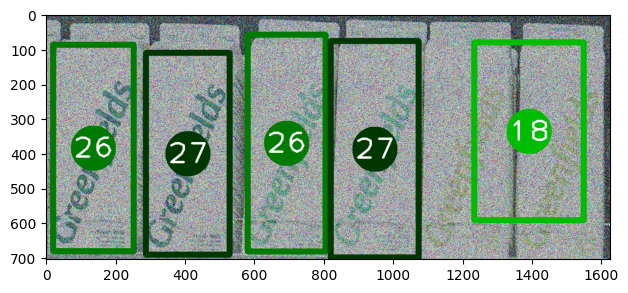

In [350]:

COLOR_RANGE=200
DRAW_CIRCLES=True
for i, scene in enumerate(products_found_B):
    image = cv2.cvtColor(cv2.imread(scenes_B[-1]), cv2.COLOR_BGR2RGB)
    prods=len(products_found_B[scene].keys())
    for c,products in enumerate(products_found_B[scene]):
        for instance in products_found_B[scene][products]:
            points = get_angles(instance['geometry'])
            color=[0,255-COLOR_RANGE+COLOR_RANGE*(prods-(c+1))/prods,0]
            # color=[np.random.randint(0,255) for _ in range(3)]
            image = cv2.polylines(image, [np.int32(points)], True, color, 15, cv2.LINE_AA)
            text=f'{products}'
            px,py=instance['geometry']['position']
            if DRAW_CIRCLES:
                image=cv2.circle(image,(px,py),65,color,-1)
                text_color=[255]*3
            else: 
                text_color=0
            px-=60
            py+=30
            image=cv2.putText(image,text,(px,py),cv2.FONT_HERSHEY_PLAIN,6,text_color,5)
plt.imshow(image)
plt.tight_layout()
plt.show()

### Draw bounding boxes:

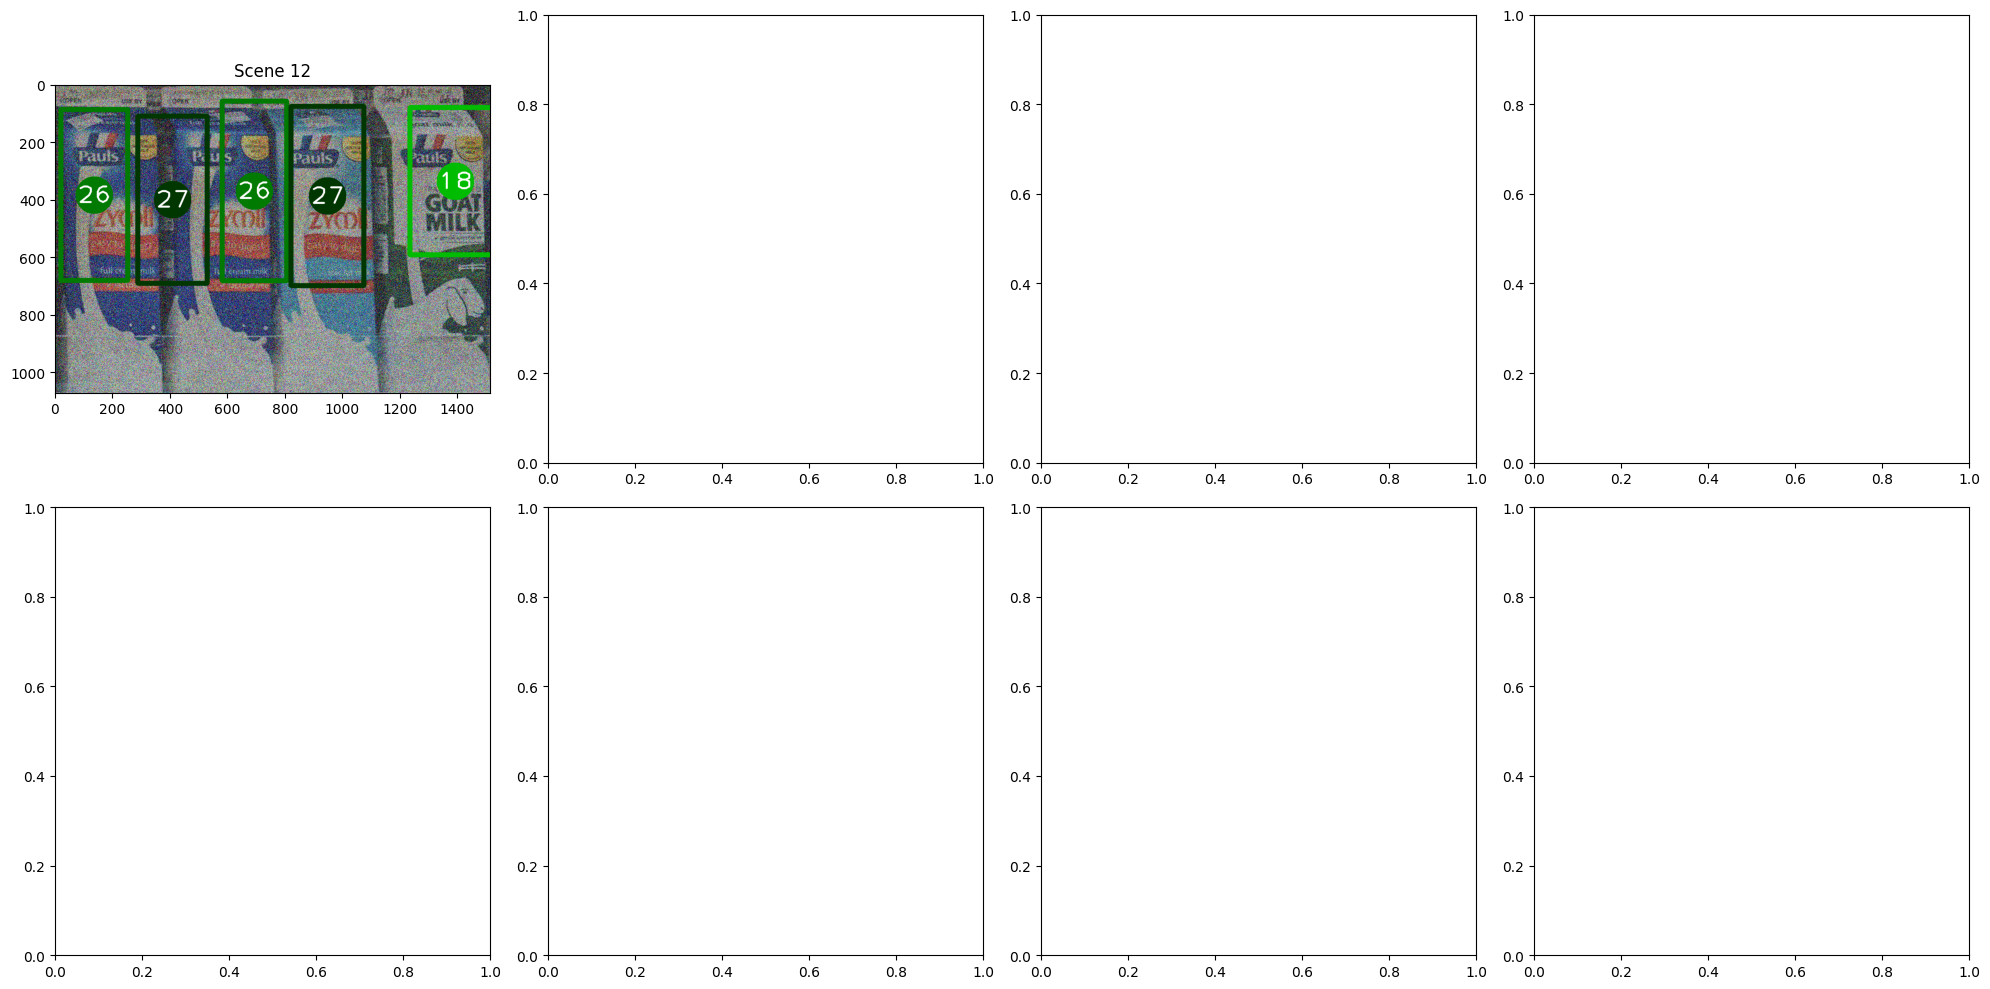

In [351]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
COLOR_RANGE=200
DRAW_CIRCLES=True
for i, scene in enumerate(products_found_B):
    image = cv2.cvtColor(cv2.imread(scenes_B[i]), cv2.COLOR_BGR2RGB)
    prods=len(products_found_B[scene].keys())
    for c,products in enumerate(products_found_B[scene]):
        for instance in products_found_B[scene][products]:
            points = get_angles(instance['geometry'])
            color=[0,255-COLOR_RANGE+COLOR_RANGE*(prods-(c+1))/prods,0]
            # color=[np.random.randint(0,255) for _ in range(3)]
            image = cv2.polylines(image, [np.int32(points)], True, color, 15, cv2.LINE_AA)
            text=f'{products}'
            px,py=instance['geometry']['position']
            if DRAW_CIRCLES:
                image=cv2.circle(image,(px,py),65,color,-1)
                text_color=[255]*3
            else: 
                text_color=0
            px-=60
            py+=30
            image=cv2.putText(image,text,(px,py),cv2.FONT_HERSHEY_PLAIN,6,text_color,5)
    axes[i].imshow(image)
    # axes[i].axis('off')
    axes[i].set_title(f'Scene {scene}')
    if i == len(scenes_B)-1:
        for ax in axes[i+1:]:
            ax.axis('off')

plt.tight_layout()
plt.show()

scene6:15,15  
scene7:16,16  
scene8: 27,23,23,24  
scene9:18,18,19,19,20,20  
scene10:21,21,22,22  
scene11:23,23,24,24,25,25,(27)  
scene12:26,26,27,27,18,18